 ## 🍅 YOLOv12 + DINOv2 SSL for Tomato Leaf Disease (WITH CHECKPOINTING)

### Group Members:
### Member 1: Tasfia Binte Jahangir (2022-3-60-111)
### Member 2: Israt Jahan Orchee (2023-1-60-028)
### Member 3: Nazratan Mazumder Niha (2022-3-60-328)
### Member 4: Shafayat Hasanat Rubaiyat (2022-3-60-029)

# 0️⃣ Setup & Install (with compatibility fixes)

In [1]:
import sys

!{sys.executable} -m pip install -q \
    "numpy==1.26.4" \
    "scipy==1.11.4" \
    "scikit-learn==1.3.2" \
    "threadpoolctl>=3.1.0,<4.0" \
    "ultralytics>=8.3.0" \
    "timm>=0.9.0" \
    "tqdm" \
    "pillow" \
    "opencv-python"

import os, json, yaml, math, gc, random, shutil, contextlib
from pathlib import Path
from PIL import Image
import cv2

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
print("Device:", device, "| torch", torch.__version__, "| numpy", np.__version__)

def autocast_ctx():
    return torch.autocast(device_type="cuda", enabled=True) if device=="cuda" else contextlib.nullcontext()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 125.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12

# 1️⃣ Copy Dataset

In [2]:
src_path = "/kaggle/input/tomato-leaf-diseases-dataset-for-object-detection"
dst_path = "/kaggle/working/tomato_dataset"

if not os.path.exists(dst_path):
    shutil.copytree(src_path, dst_path)

dataset_root = "/kaggle/working/tomato_dataset/Tomato leaf diseases dataset for Object Detection/Dataset with augmentation"

for split in ['train', 'valid', 'test']:
    img_dir = os.path.join(dataset_root, split, 'images')
    lbl_dir = os.path.join(dataset_root, split, 'labels')
    assert os.path.exists(img_dir), f"Missing {img_dir}"
    assert os.path.exists(lbl_dir), f"Missing {lbl_dir}"

# 2️⃣ Fix data.yaml

In [3]:
yaml_path = os.path.join(dataset_root, "data.yaml")
with open(yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

data_config['train'] = os.path.join(dataset_root, 'train', 'images')
data_config['val'] = os.path.join(dataset_root, 'valid', 'images')
data_config['test'] = os.path.join(dataset_root, 'test', 'images')

corrected_yaml = '/kaggle/working/data.yaml'
with open(corrected_yaml, 'w') as f:
    yaml.dump(data_config, f)

class_names = data_config["names"]

# 3️⃣ Backbone Encoder & Dataset

In [4]:
def _pick_last_feat(out):
    if isinstance(out, (list, tuple)) and len(out) > 0:
        t = out[-1]
    elif isinstance(out, dict) and len(out) > 0:
        t = list(out.values())[-1]
    else:
        t = out
    if not torch.is_tensor(t):
        if isinstance(t, (list, tuple)) and len(t) > 0 and torch.is_tensor(t[-1]):
            t = t[-1]
        elif isinstance(t, dict) and len(t) > 0 and torch.is_tensor(list(t.values())[-1]):
            t = list(t.values())[-1]
        else:
            raise RuntimeError("Backbone output type not understood.")
    return t

class BackboneEncoder(nn.Module):
    def __init__(self, bb): 
        super().__init__()
        self.bb = bb
    def forward(self, x):
        out = self.bb(x)
        t = _pick_last_feat(out)
        if t.ndim == 4:
            z = t.mean(dim=(2,3))
        elif t.ndim == 3:
            z = t.mean(dim=2)
        elif t.ndim == 2:
            z = t
        else:
            z = t.view(t.size(0), -1)
        return z

class MultiCropDINO(Dataset):
    SUPP = ('*.jpg','*.jpeg','*.png')
    def __init__(self, roots, g_size=224, l_size=96, n_local=4):  # reduced local crops
        self.files = [p for r in roots for s in self.SUPP for p in Path(r).rglob(s)]
        if not self.files: 
            raise RuntimeError("No images found for SSL.")
        self.g1 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.2,0.2,0.2,0.05),  # weaker
            transforms.ToTensor()
        ])
        self.g2 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.2,0.2,0.2,0.05),
            transforms.ToTensor()
        ])
        self.local = transforms.Compose([
            transforms.RandomResizedCrop(l_size, scale=(0.05, 0.4)),
            transforms.Resize(g_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
        ])
        self.n_local = n_local
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        crops = [self.g1(img), self.g2(img)]
        crops.extend([self.local(img) for _ in range(self.n_local)])
        return crops

# 4️⃣ Train Baseline

In [5]:
baseline_weight = "/kaggle/working/tomato_yolov12_train/yolov12_tomato_baseline/weights/best.pt"
if not os.path.exists(baseline_weight):
    print("🚀 Training baseline...")
    model_baseline = YOLO("yolo12n.pt")
    model_baseline.train(
        data=corrected_yaml,
        epochs=50,
        imgsz=640,
        batch=8,  # safer for P100
        project="/kaggle/working/tomato_yolov12_train",
        name="yolov12_tomato_baseline",
        workers=2,
        exist_ok=True
    )

best_baseline = YOLO(baseline_weight)
metrics_baseline = best_baseline.val(data=corrected_yaml, split='test', imgsz=640, batch=8)
baseline_map50 = metrics_baseline.results_dict['metrics/mAP50(B)']
baseline_map5095 = metrics_baseline.results_dict['metrics/mAP50-95(B)']
print(f"✅ Baseline mAP@0.5: {baseline_map50:.4f} | mAP@0.5:0.95: {baseline_map5095:.4f}")

🚀 Training baseline...
Ultralytics 8.3.240 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov12_tomato_baseline, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, p

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        659       1785      0.917      0.889      0.949      0.861
          Early Blight        134        163       0.91      0.902      0.963      0.895
               Healthy         91        288      0.911      0.899      0.953       0.85
           Late Blight        115        175      0.883      0.926      0.963      0.895
            Leaf Miner        127        174       0.98      0.994      0.994      0.927
             Leaf Mold        106        215      0.925      0.819      0.939      0.838
          Mosaic Virus        152        186      0.941      0.892      0.954      0.909
              Septoria        104        196      0.925      0.822      0.929      0.842
          Spider Mites         76        205       0.97      0.951      0.975      0.905
Yellow Leaf Curl Virus         64        183      0.806      0.797      0.874      0.684
Speed: 0.2ms preprocess, 3.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /kaggle/wor

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        420       1578      0.977      0.967      0.989      0.954
          Early Blight        135        162      0.975      0.946      0.988      0.959
               Healthy         57        108      0.978      0.917      0.979      0.907
           Late Blight        189        261       0.99      0.996      0.995      0.969
            Leaf Miner        122        146      0.986      0.974      0.994      0.955
             Leaf Mold        168        222       0.94      0.964      0.982      0.949
          Mosaic Virus        172        220          1      0.971      0.995      0.954
              Septoria        143        174      0.986          1      0.995      0.982
          Spider Mites         98        111      0.997      0.991      0.995       0.99
Yellow Leaf Curl Virus        116        174      0.942      0.941      0.981      0.919
Speed: 0.9ms preprocess, 4.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /kaggle/wor

# 5️⃣ DINOv2 SSL WITH CHECKPOINTING

In [6]:
# Paths
CHECKPOINT_INPUT_DIR = Path("/kaggle/input/ssl-tomato-checkpoints")  # Read-only (your upload)
FINAL_BACKBONE_PATH = "/kaggle/working/yolo12n_ssl_backbone_final.pt"  # Writable output

# Only run SSL if final backbone doesn't already exist
if not os.path.exists(FINAL_BACKBONE_PATH):
    image_roots = [
        os.path.join(dataset_root, "train", "images"),
        os.path.join(dataset_root, "valid", "images"),
        os.path.join(dataset_root, "test", "images")
    ]
    
    # Build models
    temp_model = YOLO("yolo12n.pt")
    student_bb = temp_model.model.model[0].to(device)
    teacher_bb = YOLO("yolo12n.pt").model.model[0].to(device)
    teacher_bb.load_state_dict(student_bb.state_dict())
    for p in teacher_bb.parameters():
        p.requires_grad = False

    student_enc = BackboneEncoder(student_bb).to(device)
    teacher_enc = BackboneEncoder(teacher_bb).to(device)

    with torch.no_grad():
        dmy = torch.zeros(1, 3, 224, 224, device=device)
        feat_dim = student_enc(dmy).shape[1]
    print("Backbone feature dim:", feat_dim)

    # Projector
    OUT_DIM = min(256, max(32, feat_dim * 8))
    def projector(in_dim, hid=512, out=OUT_DIM):
        return nn.Sequential(
            nn.Linear(in_dim, hid), nn.GELU(), nn.BatchNorm1d(hid),
            nn.Linear(hid, out)
        )
    student_head = projector(feat_dim).to(device)
    teacher_head = projector(feat_dim).to(device)
    teacher_head.load_state_dict(student_head.state_dict())
    for p in teacher_head.parameters():
        p.requires_grad = False

    # DINOLoss
    class DINOLoss(nn.Module):
        def __init__(self, out_dim, n_global=2, teacher_temp_warm=0.04, teacher_temp=0.07,
                     warmup_frac=0.1, total_epochs=50, center_m=0.9, student_temp=0.1):
            super().__init__()
            self.n_global = n_global
            self.t_warm, self.t_final = teacher_temp_warm, teacher_temp
            self.warmup_frac, self.T = warmup_frac, total_epochs
            self.cm = center_m
            self.student_temp = student_temp
            self.register_buffer("center", torch.zeros(1, out_dim))
        
        def teacher_T(self, epoch):
            if epoch < self.warmup_frac * self.T:
                a = epoch / (self.warmup_frac * self.T)
                return self.t_warm + (self.t_final - self.t_warm) * a
            return self.t_final
        
        def forward(self, s_out, t_out, epoch):
            Tt = self.teacher_T(epoch)
            s_logits = [s / self.student_temp for s in s_out]
            t_probs = [F.softmax((t - self.center) / Tt, dim=-1).detach() for t in t_out]
            loss = 0
            cnt = 0
            for iq, q in enumerate(t_probs):
                for v, s in enumerate(s_logits):
                    if v == iq:
                        continue
                    loss += -(q * F.log_softmax(s, dim=-1)).sum(1).mean()
                    cnt += 1
            loss /= max(cnt, 1)
            with torch.no_grad():
                batch_center = torch.cat(t_out, 0).mean(0, keepdim=True)
                self.center = self.center * self.cm + (1 - self.cm) * batch_center
            return loss

    # Dataset
    ds = MultiCropDINO(image_roots, g_size=224, l_size=96, n_local=2)
    dl = DataLoader(ds, batch_size=4, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

    # Optimizer
    EPOCHS = 50 
    params = list(student_enc.parameters()) + list(student_head.parameters())
    opt = torch.optim.AdamW(params, lr=5e-4, weight_decay=0.05)
    lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
    scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))
    loss_fn = DINOLoss(OUT_DIM, total_epochs=EPOCHS).to(device)

    # Resume from checkpoint in INPUT directory
    start_epoch = 0
    checkpoint_files = sorted(CHECKPOINT_INPUT_DIR.glob("checkpoint_ep*.pt"))
    if checkpoint_files:
        latest = checkpoint_files[-1]
        print(f"🔁 Resuming from {latest}")
        ckpt = torch.load(latest, map_location=device)
        student_bb.load_state_dict(ckpt['student_bb'])
        teacher_bb.load_state_dict(ckpt['teacher_bb'])
        student_head.load_state_dict(ckpt['student_head'])
        teacher_head.load_state_dict(ckpt['teacher_head'])
        opt.load_state_dict(ckpt['optimizer'])
        if scaler and 'scaler' in ckpt:
            scaler.load_state_dict(ckpt['scaler'])
        start_epoch = ckpt['epoch'] + 1

    # Writable directory for new checkpoints
    SAVE_CHECKPOINT_DIR = Path("/kaggle/working/ssl_checkpoints")
    SAVE_CHECKPOINT_DIR.mkdir(exist_ok=True)

    # Training loop
    steps_per_epoch = len(dl)
    total_steps = steps_per_epoch * EPOCHS
    student_enc.train()
    student_head.train()
    
    for ep in range(start_epoch, EPOCHS):
        ep_loss = 0.0
        for views in tqdm(dl, desc=f"SSL Ep {ep+1}/{EPOCHS}", leave=True):
            views = [v.to(device) for v in views]
            with autocast_ctx():
                s_feats = [student_enc(v) for v in views]
                s_outs = [student_head(z) for z in s_feats]
                with torch.no_grad():
                    t_feats = [teacher_enc(v) for v in views[:2]]
                    t_outs = [teacher_head(z) for z in t_feats]
                loss = loss_fn(s_outs, t_outs, epoch=ep)

            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            nn.utils.clip_grad_norm_(params, 3.0)
            scaler.step(opt)
            scaler.update()
            opt.zero_grad()

            # EMA update
            gstep = ep * steps_per_epoch + dl.batch_size
            m = 1 - (1 - 0.996) * (math.cos(math.pi * gstep / total_steps) + 1) / 2
            with torch.no_grad():
                for ps, pt in zip(student_bb.parameters(), teacher_bb.parameters()):
                    pt.data.mul_(m).add_(ps.data, alpha=1 - m)
                for ps, pt in zip(student_head.parameters(), teacher_head.parameters()):
                    pt.data.mul_(m).add_(ps.data, alpha=1 - m)

            ep_loss += loss.item()
        
        lr_sched.step()
        print(f"SSL Epoch {ep+1:02d}: avg loss = {ep_loss / steps_per_epoch:.4f}")

        # Save checkpoint every 5 epochs to WORKING (writable)
        if (ep + 1) % 5 == 0 or ep == EPOCHS - 1:
            torch.save({
                'epoch': ep,
                'student_bb': student_bb.state_dict(),
                'teacher_bb': teacher_bb.state_dict(),
                'student_head': student_head.state_dict(),
                'teacher_head': teacher_head.state_dict(),
                'optimizer': opt.state_dict(),
                'scaler': scaler.state_dict() if scaler else None,
            }, SAVE_CHECKPOINT_DIR / f"checkpoint_ep{ep+1}.pt")
            print(f"💾 Checkpoint saved at epoch {ep+1}")

    # Save final backbone to WORKING (writable)
    torch.save(student_bb.state_dict(), FINAL_BACKBONE_PATH)
    print("✅ SSL backbone saved:", FINAL_BACKBONE_PATH)
else:
    print("✅ SSL backbone already exists. Skipping pretraining.")

Backbone feature dim: 16
🔁 Resuming from /kaggle/input/ssl-tomato-checkpoints/checkpoint_ep20.pt


/tmp/ipykernel_21/4264429433.py:87: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))


SSL Ep 21/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 21: avg loss = 4.2472


SSL Ep 22/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 22: avg loss = 4.2397


SSL Ep 23/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 23: avg loss = 4.2385


SSL Ep 24/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 24: avg loss = 4.2485


SSL Ep 25/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 25: avg loss = 4.2458
💾 Checkpoint saved at epoch 25


SSL Ep 26/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 26: avg loss = 4.2548


SSL Ep 27/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 27: avg loss = 4.2447


SSL Ep 28/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 28: avg loss = 4.2421


SSL Ep 29/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 29: avg loss = 4.2466


SSL Ep 30/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 30: avg loss = 4.2487
💾 Checkpoint saved at epoch 30


SSL Ep 31/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 31: avg loss = 4.2446


SSL Ep 32/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 32: avg loss = 4.2393


SSL Ep 33/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 33: avg loss = 4.2476


SSL Ep 34/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 34: avg loss = 4.2464


SSL Ep 35/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 35: avg loss = 4.2487
💾 Checkpoint saved at epoch 35


SSL Ep 36/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 36: avg loss = 4.2464


SSL Ep 37/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 37: avg loss = 4.2423


SSL Ep 38/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 38: avg loss = 4.2420


SSL Ep 39/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 39: avg loss = 4.2457


SSL Ep 40/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 40: avg loss = 4.2439
💾 Checkpoint saved at epoch 40


SSL Ep 41/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 41: avg loss = 4.2467


SSL Ep 42/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 42: avg loss = 4.2508


SSL Ep 43/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 43: avg loss = 4.2456


SSL Ep 44/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 44: avg loss = 4.2501


SSL Ep 45/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 45: avg loss = 4.2468
💾 Checkpoint saved at epoch 45


SSL Ep 46/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 46: avg loss = 4.2448


SSL Ep 47/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 47: avg loss = 4.2482


SSL Ep 48/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 48: avg loss = 4.2419


SSL Ep 49/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 49: avg loss = 4.2430


SSL Ep 50/50:   0%|          | 0/2702 [00:00<?, ?it/s]

SSL Epoch 50: avg loss = 4.2365
💾 Checkpoint saved at epoch 50
✅ SSL backbone saved: /kaggle/working/yolo12n_ssl_backbone_final.pt


# 6️⃣ Fine-Tune with SSL Backbone

In [7]:
def compute_classification_metrics(model, img_dir, label_dir, class_names, confidence=0.001):
    """
    Compute micro-averaged Precision, Recall, F1, and Accuracy for object detection as a classification task.
    We treat each image as having one dominant label (the true class from label file),
    and the model's top predicted class as its output.
    """
    from sklearn.metrics import precision_recall_fscore_support, accuracy_score
    
    true_labels = []
    pred_labels = []
    
    label_paths = list(Path(label_dir).glob("*.txt"))
    
    for lbl_path in tqdm(label_paths, desc="Evaluating classification metrics"):
        # Get true label (assume single-class per image, take first class in label file)
        with open(lbl_path, 'r') as f:
            lines = f.readlines()
        if not lines:
            continue
        true_class = int(float(lines[0].split()[0]))  # first object's class
        true_labels.append(true_class)
        
        # Get image path
        img_path = Path(img_dir) / f"{lbl_path.stem}.jpg"
        if not img_path.exists():
            img_path = Path(img_dir) / f"{lbl_path.stem}.png"
        if not img_path.exists():
            true_labels.pop()
            continue

        # Run inference
        results = model(img_path, verbose=False, conf=confidence)
        boxes = results[0].boxes

        if len(boxes) == 0:
            # No detection → predict background or most common class? We'll skip or assign -1
            pred_labels.append(-1)  # will be excluded in metrics if we filter
        else:
            # Get class with highest confidence
            confs = boxes.conf.cpu().numpy()
            classes = boxes.cls.cpu().numpy()
            best_idx = np.argmax(confs)
            pred_labels.append(int(classes[best_idx]))
    
    # Filter out unmatched or skipped images
    valid_indices = [i for i, pred in enumerate(pred_labels) if pred != -1]
    y_true = [true_labels[i] for i in valid_indices]
    y_pred = [pred_labels[i] for i in valid_indices]

    # Compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
        'num_samples': len(y_true)
    }

In [8]:
print("\n🔧 Fine-tuning with SSL backbone...")
ssl_model = YOLO("yolo12n.pt")
ssl_model.model.model[0].load_state_dict(
    torch.load("/kaggle/working/yolo12n_ssl_backbone_final.pt", map_location="cpu")
)
ssl_model.train(
    data=corrected_yaml,
    epochs=50,
    imgsz=640,
    batch=8,
    project="/kaggle/working/tomato_yolov12_ssl",
    name="yolov12_tomato_ssl",
    workers=2,
    exist_ok=True
)

best_ssl = YOLO("/kaggle/working/tomato_yolov12_ssl/yolov12_tomato_ssl/weights/best.pt")
metrics_ssl = best_ssl.val(data=corrected_yaml, split='test', imgsz=640, batch=8)
ssl_map50 = metrics_ssl.results_dict['metrics/mAP50(B)']
ssl_map5095 = metrics_ssl.results_dict['metrics/mAP50-95(B)']


🔧 Fine-tuning with SSL backbone...
Ultralytics 8.3.240 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov12_tomato_ssl, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        659       1785      0.917      0.889      0.949      0.861
          Early Blight        134        163       0.91      0.902      0.963      0.895
               Healthy         91        288      0.911      0.899      0.953       0.85
           Late Blight        115        175      0.883      0.926      0.963      0.895
            Leaf Miner        127        174       0.98      0.994      0.994      0.927
             Leaf Mold        106        215      0.925      0.819      0.939      0.838
          Mosaic Virus        152        186      0.941      0.892      0.954      0.909
              Septoria        104        196      0.925      0.822      0.929      0.842
          Spider Mites         76        205       0.97      0.951      0.975      0.905
Yellow Leaf Curl Virus         64        183      0.806      0.797      0.874      0.684
Speed: 0.2ms preprocess, 4.3ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /kaggle/wor

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        420       1578      0.977      0.967      0.989      0.954
          Early Blight        135        162      0.975      0.946      0.988      0.959
               Healthy         57        108      0.978      0.917      0.979      0.907
           Late Blight        189        261       0.99      0.996      0.995      0.969
            Leaf Miner        122        146      0.986      0.974      0.994      0.955
             Leaf Mold        168        222       0.94      0.964      0.982      0.949
          Mosaic Virus        172        220          1      0.971      0.995      0.954
              Septoria        143        174      0.986          1      0.995      0.982
          Spider Mites         98        111      0.997      0.991      0.995       0.99
Yellow Leaf Curl Virus        116        174      0.942      0.941      0.981      0.919
Speed: 1.2ms preprocess, 4.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/wor

In [9]:
print("\n📊 FINAL COMPARISON:")

# Get test paths
test_img_dir = os.path.join(dataset_root, "test", "images")
test_lbl_dir = os.path.join(dataset_root, "test", "labels")

# Compute extended metrics
print("Computing detailed metrics for Baseline...")
baseline_metrics_ext = compute_classification_metrics(best_baseline, test_img_dir, test_lbl_dir, class_names)

print("Computing detailed metrics for SSL + FT...")
ssl_metrics_ext = compute_classification_metrics(best_ssl, test_img_dir, test_lbl_dir, class_names)

# Original mAP values
print(f"Baseline   → mAP@0.5: {baseline_map50:.4f} | mAP@0.5:0.95: {baseline_map5095:.4f}")
print(f"SSL + FT   → mAP@0.5: {ssl_map50:.4f}    | mAP@0.5:0.95: {ssl_map5095:.4f}")

# Additional metrics
print("\n" + "="*70)
print("🎯 Extended Classification Metrics (Weighted Avg):")
print("="*70)
print(f"{'Metric':<12} {'Baseline':<12} {'SSL + FT':<12}")
print("-"*70)
print(f"{'Precision':<12} {baseline_metrics_ext['precision']:<12.4f} {ssl_metrics_ext['precision']:<12.4f}")
print(f"{'Recall':<12} {baseline_metrics_ext['recall']:<12.4f} {ssl_metrics_ext['recall']:<12.4f}")
print(f"{'F1-Score':<12} {baseline_metrics_ext['f1']:<12.4f} {ssl_metrics_ext['f1']:<12.4f}")
print(f"{'Accuracy':<12} {baseline_metrics_ext['accuracy']:<12.4f} {ssl_metrics_ext['accuracy']:<12.4f}")
print(f"{'Samples':<12} {baseline_metrics_ext['num_samples']:<12} {ssl_metrics_ext['num_samples']:<12}")


📊 FINAL COMPARISON:
Computing detailed metrics for Baseline...


Evaluating classification metrics:   0%|          | 0/420 [00:00<?, ?it/s]

Computing detailed metrics for SSL + FT...


Evaluating classification metrics:   0%|          | 0/420 [00:00<?, ?it/s]

Baseline   → mAP@0.5: 0.9893 | mAP@0.5:0.95: 0.9540
SSL + FT   → mAP@0.5: 0.9893    | mAP@0.5:0.95: 0.9540

🎯 Extended Classification Metrics (Weighted Avg):
Metric       Baseline     SSL + FT    
----------------------------------------------------------------------
Precision    0.5007       0.5007      
Recall       0.4738       0.4738      
F1-Score     0.4719       0.4719      
Accuracy     0.4738       0.4738      
Samples      420          420         


# 7️⃣ PCA Visualization


🎨 Generating PCA...


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


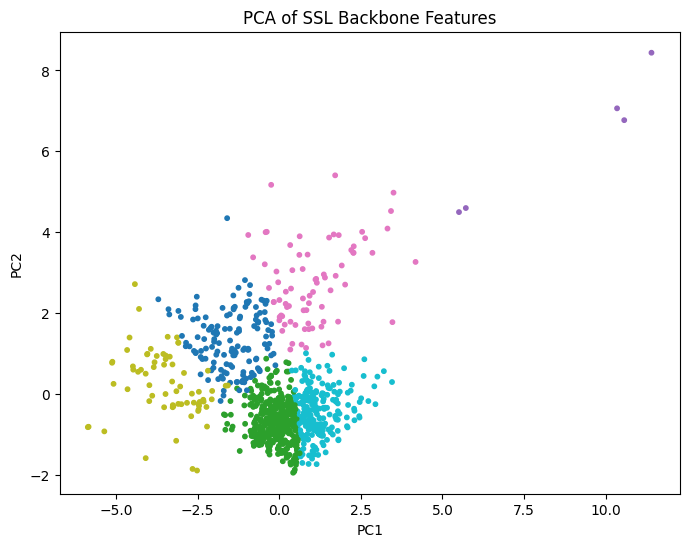

In [10]:
print("\n🎨 Generating PCA...")
pca_model = YOLO("yolo12n.pt")
pca_model.model.model[0].load_state_dict(torch.load(FINAL_BACKBONE_PATH, map_location="cpu"))
bb = pca_model.model.model[0].to(device).eval()
enc = BackboneEncoder(bb).to(device)

IMG_DIRS = [Path(dataset_root)/"train"/"images", Path(dataset_root)/"valid"/"images"]
files = [f for d in IMG_DIRS for f in d.glob("*.*")][:1000]

tfm = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
feats = []
with torch.no_grad():
    for p in files:
        try:
            img = Image.open(p).convert("RGB")
            x = tfm(img).unsqueeze(0).to(device)
            z = enc(x)
            feats.append(z.squeeze(0).cpu().numpy())
        except:
            continue

feats = np.stack(feats)
pca = PCA(n_components=2, random_state=42)
xy = pca.fit_transform(feats)
kmeans = KMeans(n_clusters=min(6, len(class_names)), random_state=42).fit(feats)

plt.figure(figsize=(8,6))
plt.scatter(xy[:,0], xy[:,1], c=kmeans.labels_, s=10, cmap="tab10")
plt.title("PCA of SSL Backbone Features")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

 # 8️⃣  Display training and validation metrics

Displaying training and validation metrics...

📊 Baseline Training Metrics:


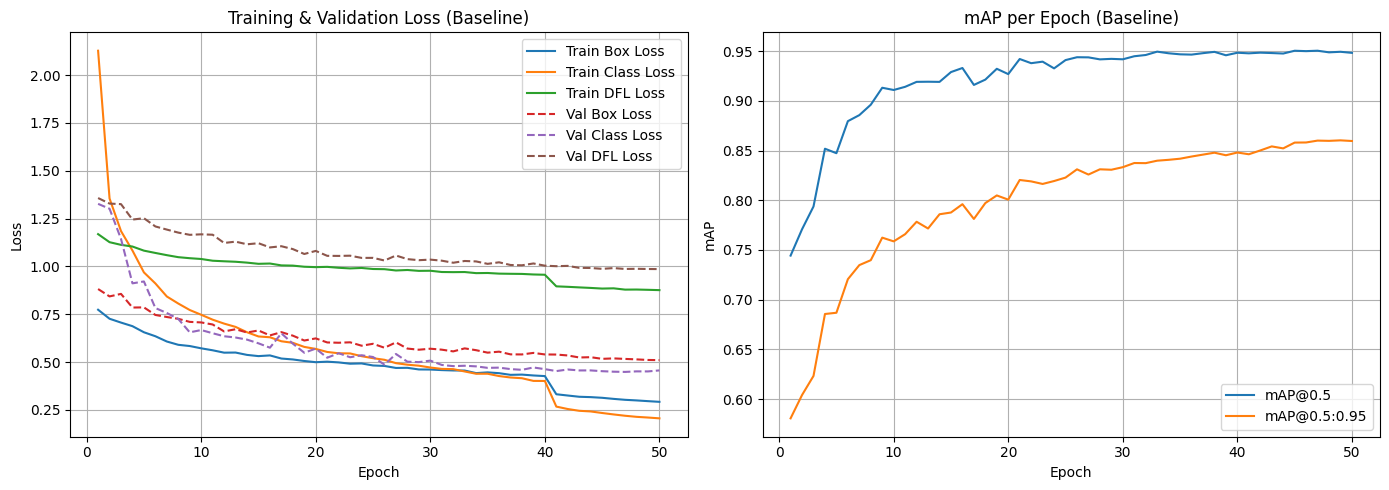


📊 SSL + Fine-tuning Metrics:


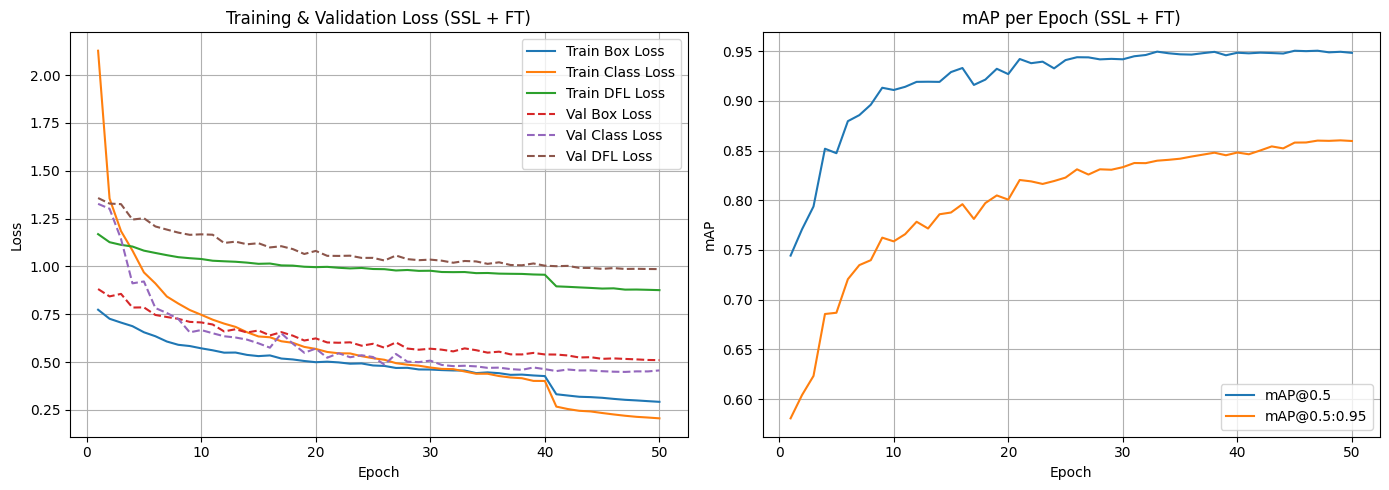


✅ Metric display complete.


In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt

print("Displaying training and validation metrics...")

# Paths to results.csv for both runs
baseline_results = "/kaggle/working/tomato_yolov12_train/yolov12_tomato_baseline/results.csv"
ssl_results = "/kaggle/working/tomato_yolov12_ssl/yolov12_tomato_ssl/results.csv"

def plot_results(results_path, title_suffix=""):
    if os.path.exists(results_path):
        results_df = pd.read_csv(results_path)

        plt.figure(figsize=(14, 5))

        # Losses
        plt.subplot(1, 2, 1)
        plt.plot(results_df['epoch'], results_df['train/box_loss'], label='Train Box Loss')
        plt.plot(results_df['epoch'], results_df['train/cls_loss'], label='Train Class Loss')
        plt.plot(results_df['epoch'], results_df['train/dfl_loss'], label='Train DFL Loss')
        plt.plot(results_df['epoch'], results_df['val/box_loss'], '--', label='Val Box Loss')
        plt.plot(results_df['epoch'], results_df['val/cls_loss'], '--', label='Val Class Loss')
        plt.plot(results_df['epoch'], results_df['val/dfl_loss'], '--', label='Val DFL Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training & Validation Loss {title_suffix}')
        plt.legend()
        plt.grid(True)

        # mAP
        plt.subplot(1, 2, 2)
        plt.plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP@0.5')
        plt.plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
        plt.xlabel('Epoch')
        plt.ylabel('mAP')
        plt.title(f'mAP per Epoch {title_suffix}')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()
    else:
        print(f"⚠️ Results file not found at {results_path}")

# Plot both if they exist
print("\n📊 Baseline Training Metrics:")
plot_results(baseline_results, "(Baseline)")

print("\n📊 SSL + Fine-tuning Metrics:")
plot_results(ssl_results, "(SSL + FT)")

print("\n✅ Metric display complete.")

# 9️⃣ Explainability: Feature Activation Map (XAI)

🎯 Found examples for 9 / 9 classes.


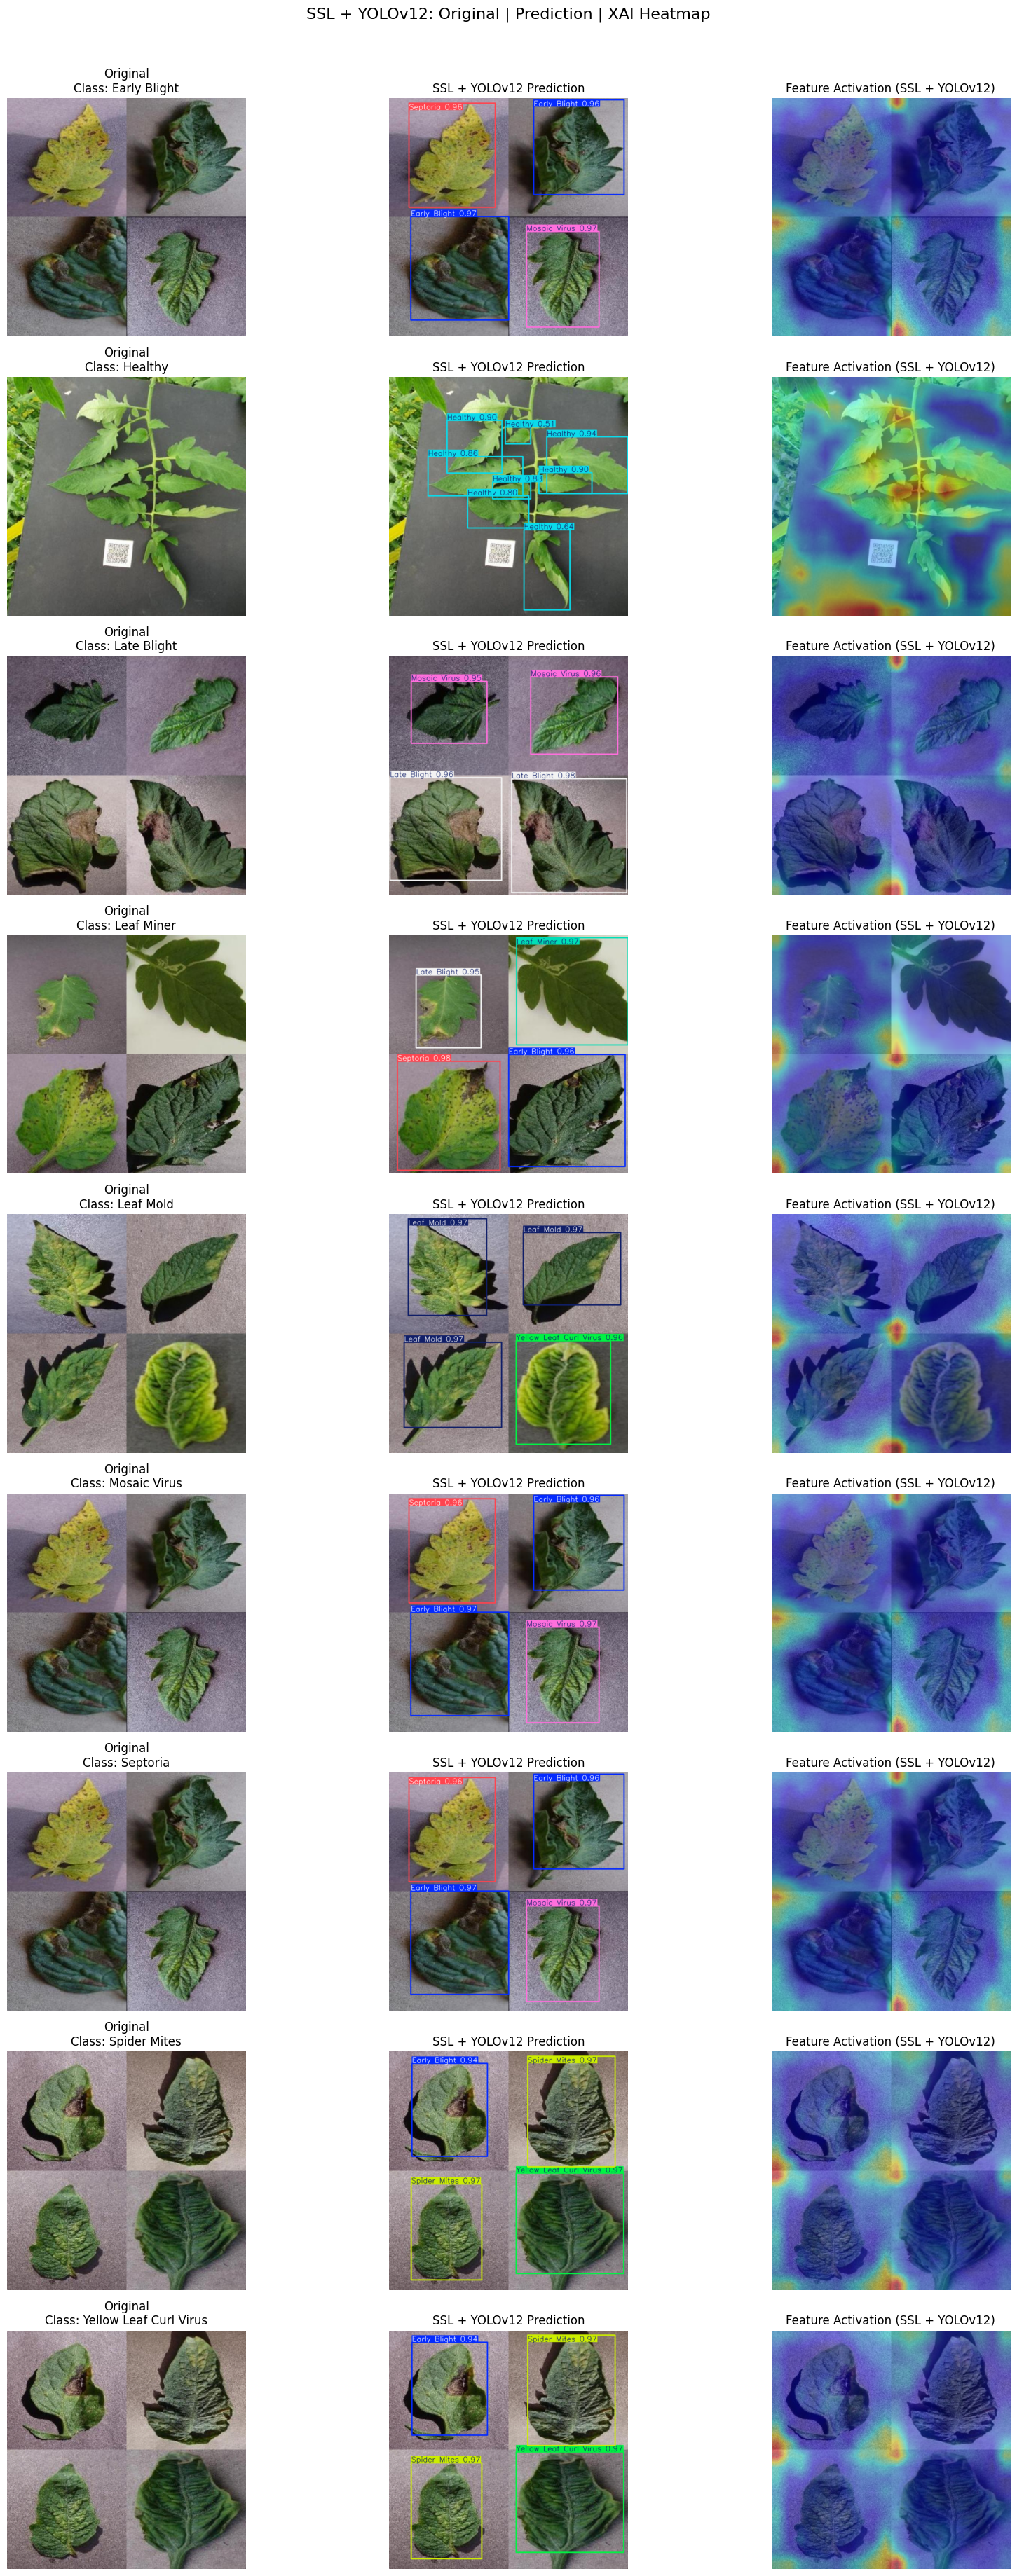

In [12]:
# ------------------------------------------------------------
# XAI: Feature Activation Map for SSL + YOLOv12 Model
# ------------------------------------------------------------
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

# Use the SSL-finetuned model
best_model = best_ssl  # ← Only change from original

# Get all test images and their labels
test_img_dir = Path(dataset_root) / "test" / "images"
test_lbl_dir = Path(dataset_root) / "test" / "labels"

# Build mapping: class_id -> list of (img_path, bbox)
class_to_examples = defaultdict(list)

for lbl_path in test_lbl_dir.glob("*.txt"):
    img_path = test_img_dir / f"{lbl_path.stem}.jpg"
    if not img_path.exists():
        img_path = test_img_dir / f"{lbl_path.stem}.png"
    if not img_path.exists():
        continue

    with open(lbl_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            cls_id = int(float(parts[0]))
            # Store first bbox per image per class (simplification)
            if len(class_to_examples[cls_id]) < 1:  # only 1 example per class
                class_to_examples[cls_id].append((img_path, list(map(float, parts))))

# Sort by class ID for consistent order
examples_per_class = [class_to_examples[i][0] for i in range(len(class_names)) if i in class_to_examples]

print(f"🎯 Found examples for {len(examples_per_class)} / {len(class_names)} classes.")

# Feature map extraction function (same as before)
def get_activation_overlay(model, img_path, layer_idx=-3):
    model.model.eval()
    img = cv2.imread(str(img_path))
    if img is None:
        raise ValueError(f"Could not load image: {img_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    input_tensor = cv2.resize(img_rgb, (640, 640))
    input_tensor = torch.from_numpy(input_tensor).float().permute(2,0,1).unsqueeze(0).to(model.device) / 255.0

    activation = {}
    def hook(m, inp, out): activation['feat'] = out.detach()
    target_layer = list(model.model.model.children())[layer_idx]
    handle = target_layer.register_forward_hook(hook)
    
    with torch.no_grad():
        _ = model.model(input_tensor)
    handle.remove()
    
    feat = activation['feat'].cpu().mean(dim=1).squeeze().numpy()
    feat = (feat - feat.min()) / (feat.max() - feat.min() + 1e-8)
    feat = cv2.resize(feat, (w, h))
    heatmap = cv2.applyColorMap(np.uint8(255 * feat), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    return img, overlay

# Plot one row per class
plt.figure(figsize=(18, 4 * len(examples_per_class)))

for idx, (img_path, label_parts) in enumerate(examples_per_class):
    cls_id = int(label_parts[0])
    class_name = class_names[cls_id]

    # 1. Original image
    orig_img = cv2.imread(str(img_path))
    orig_rgb = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    # 2. Prediction with bounding box
    pred_result = best_model(img_path)[0]
    pred_img = pred_result.plot()  # BGR
    pred_rgb = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    # 3. Activation map
    _, activation_overlay = get_activation_overlay(best_model, img_path)

    # Plot all three side-by-side
    plt.subplot(len(examples_per_class), 3, idx * 3 + 1)
    plt.imshow(orig_rgb)
    plt.title(f"Original\nClass: {class_name}", fontsize=12)
    plt.axis("off")

    plt.subplot(len(examples_per_class), 3, idx * 3 + 2)
    plt.imshow(pred_rgb)
    plt.title(f"SSL + YOLOv12 Prediction", fontsize=12)  # ← Updated title
    plt.axis("off")

    plt.subplot(len(examples_per_class), 3, idx * 3 + 3)
    plt.imshow(cv2.cvtColor(activation_overlay, cv2.COLOR_BGR2RGB))
    plt.title("Feature Activation (SSL + YOLOv12)", fontsize=12)  # ← Updated title
    plt.axis("off")

plt.tight_layout()
plt.suptitle("SSL + YOLOv12: Original | Prediction | XAI Heatmap", y=1.02, fontsize=16)
plt.show()